# 02 — Light Cleaning & Operational EDA  
**Project:** SupportOps  
**Phase:** 2 (Cleaning & Exploration)

**Goal:**  
Convert raw ticket telemetry into defensible operational insights that justify KPI selection for:
1) Prioritization (what to work next)  
2) Backlog control (are we drowning or recovering)  
3) Operational visibility (where issues cluster and why)

## 1. What Phase 2 Does (and does NOT do)

### Phase 2 Does:
- Apply *light standardization* (trim whitespace, normalize casing)
- Validate and correct category consistency (e.g., "Tech Support" vs "Technical Support")
- Reshape multi-column tags into an analysis-friendly format
- Surface operational patterns (volume, mix, workload concentration, recurring issues)

### Phase 2 Does NOT:
- Translate text to English (not needed for ops KPIs)
- Invent SLA, aging, or time-to-resolution metrics (timestamps are not present)
- Build the dashboard yet (that comes later)

## 2. Load the Raw Data

We load the raw CSV as-is, then perform cleaning on a copy of the dataset.

In [1]:
import pandas as pd

RAW_PATH = "../data/raw/dataset-tickets-multi-lang-4-20k.csv"

df_raw = pd.read_csv(RAW_PATH)
df = df_raw.copy()

df.shape, df.columns

((20000, 15),
 Index(['subject', 'body', 'answer', 'type', 'queue', 'priority', 'language',
        'tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8'],
       dtype='object'))

## 3. Quick Sanity Checks

We confirm expected schema and validate that key operational columns exist and are non-null:
- `priority`
- `queue`
- `type`
- `language`

In [2]:
key_cols = ["priority", "queue", "type", "language"]

df[key_cols].isnull().sum(), df.head(3)

(priority    0
 queue       0
 type        0
 language    0
 dtype: int64,
                                              subject  \
 0  Unvorhergesehener Absturz der Datenanalyse-Pla...   
 1                           Customer Support Inquiry   
 2                      Data Analytics for Investment   
 
                                                 body  \
 0  Die Datenanalyse-Plattform brach unerwartet ab...   
 1  Seeking information on digital strategies that...   
 2  I am contacting you to request information on ...   
 
                                               answer      type  \
 0  Ich werde Ihnen bei der Lösung des Problems he...  Incident   
 1  We offer a variety of digital strategies and s...   Request   
 2  I am here to assist you with data analytics to...   Request   
 
               queue priority language      tag_1      tag_2     tag_3  \
 0   General Inquiry      low       de      Crash  Technical       Bug   
 1  Customer Service   medium       en   Feedba

## 4. Light Standardization (Minimal, Defensible)

This cleaning step improves grouping reliability without changing meaning.

We will:
- Trim whitespace
- Normalize casing (lowercase)
- Leave text fields (`subject`, `body`, `answer`) unchanged

This prevents fake duplicates such as:
- "High" vs "high"
- "Technical Support " vs "technical support"

In [3]:
cat_cols = ["priority", "queue", "type", "language"]

for col in cat_cols:
    df[col] = df[col].astype(str).str.strip().str.lower()

df[cat_cols].head()

,priority,queue,type,language
0,low,general inquiry,incident,de
1,medium,customer service,request,en
2,medium,customer service,request,en
3,high,customer service,incident,de
4,medium,customer service,request,en


## 5. Evidence Check: Before vs After Cleaning

We validate that normalization reduced category fragmentation (if it existed).

In [4]:
def unique_counts(dataframe, cols):
    return pd.Series({c: dataframe[c].nunique(dropna=False) for c in cols}).sort_values(ascending=False)

before_unique = unique_counts(df_raw, cat_cols)
after_unique = unique_counts(df, cat_cols)

before_unique, after_unique

(queue       10
 type         4
 priority     3
 language     2
 dtype: int64,
 queue       10
 type         4
 priority     3
 language     2
 dtype: int64)

## 6. Operational EDA — Priority Mix

This shows how workload is distributed across urgency levels.  
This directly supports **prioritization**.

In [5]:
priority_counts = df["priority"].value_counts(dropna=False)
priority_counts

priority
medium    8144
high      7801
low       4055
Name: count, dtype: int64

## 7. Operational EDA — Queue Workload Concentration

Queues represent routing / ownership at an operational level.  
We check whether work is concentrated in a few queues or spread evenly.

This supports:
- **backlog control** (where pressure accumulates)
- **operational visibility** (where teams may be overloaded)

In [6]:
queue_counts = df["queue"].value_counts(dropna=False)
queue_counts.head(15)

queue
technical support                  5824
product support                    3708
customer service                   3152
it support                         2292
billing and payments               2086
returns and exchanges              1001
service outages and maintenance     764
sales and pre-sales                 572
human resources                     338
general inquiry                     263
Name: count, dtype: int64

## 8. Operational EDA — Ticket Type Mix

Ticket type indicates what kind of work dominates support operations (incident vs request vs problem, etc.).  
This helps operational leaders understand what kind of workload they are dealing with.

In [7]:
type_counts = df["type"].value_counts(dropna=False)
type_counts

type
incident    7978
request     5763
problem     4184
change      2075
Name: count, dtype: int64

## 9. Reshape Tags into a Long Format (Critical)

Tags are spread across multiple columns (`tag_1` ... `tag_8`).  
For analysis, we reshape them into a single column so we can count recurring issues cleanly.

This supports:
- **operational visibility** (what issues recur)
- identifying **deflection opportunities** (what could be handled via self-service)

In [8]:
tag_cols = [c for c in df.columns if c.startswith("tag_")]

tags_long = (
    df[["language"] + tag_cols]
    .melt(id_vars=["language"], value_vars=tag_cols, value_name="tag")
    .drop(columns=["variable"])
    .dropna()
)

tags_long.shape, tags_long.head()

((104597, 2),
   language        tag
 0       de      Crash
 1       en   Feedback
 2       en  Technical
 3       de   Security
 4       en   Security)

## 10. Top Issues (Tags)

We identify:
- Top recurring issues overall
- Differences by language segment (English vs German)

This helps explain *where we are failing and why*.

In [9]:
top_tags = tags_long["tag"].value_counts().head(20)
top_tags

tag
Tech Support     8051
IT               8002
Documentation    7062
Feedback         6767
Performance      6629
Bug              6572
Technical        5804
Security         4754
Resolution       4165
Feature          3469
Guidance         2883
Product          2597
Customer         2298
Crash            1919
Outage           1898
Network          1890
Integration      1538
Sales            1527
Disruption       1361
Billing          1252
Name: count, dtype: int64

In [10]:
top_tags_by_lang = (
    tags_long.groupby("language")["tag"]
    .value_counts()
    .groupby(level=0)
    .head(10)
)

top_tags_by_lang

language  tag          
de        IT               3270
          Tech Support     3204
          Bug              2994
          Feedback         2857
          Documentation    2830
          Performance      2742
          Technical        2273
          Security         1963
          Resolution       1755
          Feature          1418
en        Tech Support     4847
          IT               4732
          Documentation    4232
          Feedback         3910
          Performance      3887
          Bug              3578
          Technical        3531
          Security         2791
          Resolution       2410
          Feature          2051
Name: count, dtype: int64

## 11. Phase 2 Summary & Implications

### What We Found

Phase 2 explored operational patterns in the support ticket data using light, defensible EDA.

Key findings:

- **Priority Mix**
  - The majority of tickets are medium priority, followed by high and low.
  - This suggests sustained operational load rather than rare, isolated emergencies.

- **Queue Workload Concentration**
  - Ticket volume is concentrated in a small number of queues (e.g., Technical Support, Product Support).
  - This indicates uneven operational pressure and potential capacity risk in specific teams.

- **Ticket Type Mix**
  - Incidents dominate the workload, followed by requests and problems.
  - Support operations are primarily reactive rather than change-driven.

- **Recurring Issues (Tags)**
  - A small set of issue categories appears repeatedly across tickets.
  - These recurring tags represent candidates for deflection, documentation, or self-service.

- **Language Segmentation**
  - Issue patterns are broadly similar across English and German tickets, with some variation in frequency.
  - Language can be treated as a segmentation dimension rather than a blocker for KPI reporting.

### What This Enables

These findings support the three core SupportOps goals:

1. **Prioritization**  
   Priority and ticket type distributions inform what should be worked first.

2. **Backlog Control (Proxy)**  
   Queue concentration highlights where workload pressure accumulates.

3. **Operational Visibility**  
   Recurring issue patterns explain where and why support teams are spending time.

### Known Limitations

- The dataset does not include timestamps, so true backlog aging, SLA breach rates, and time-to-resolution metrics cannot be calculated.
- Findings are volume- and mix-based, not time-based.

### Next Phase

Phase 3 will reshape this cleaned and explored data into a BI-friendly reporting model (fact table + dimensions) to support stable KPI calculation and SQL analytics.

## Appendix: Supporting Visuals

# Tickets by Priority

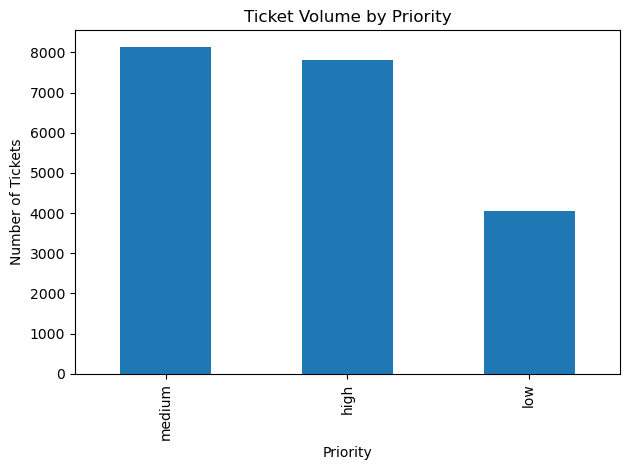

In [11]:
import matplotlib.pyplot as plt

priority_counts = df['priority'].value_counts(dropna=False)

plt.figure()
priority_counts.plot(kind='bar')
plt.title('Ticket Volume by Priority')
plt.xlabel('Priority')
plt.ylabel('Number of Tickets')
plt.tight_layout()
plt.show()

# Tickets by Queue (Top 10)

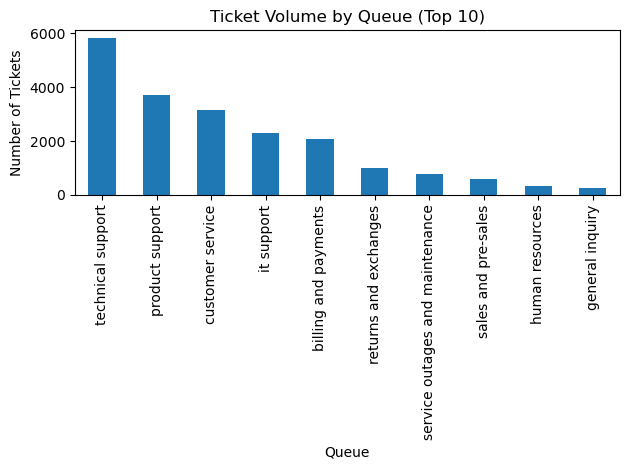

In [12]:
queue_counts = df['queue'].value_counts(dropna=False).head(10)

plt.figure()
queue_counts.plot(kind='bar')
plt.title('Ticket Volume by Queue (Top 10)')
plt.xlabel('Queue')
plt.ylabel('Number of Tickets')
plt.tight_layout()
plt.show()

# Top Issue Tags

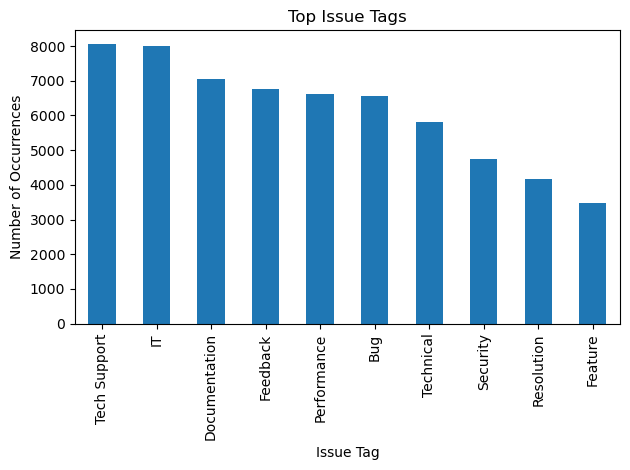

In [14]:
top_tags = tags_long['tag'].value_counts().head(10)

plt.figure()
top_tags.plot(kind='bar')
plt.title('Top Issue Tags')
plt.xlabel('Issue Tag')
plt.ylabel('Number of Occurrences')
plt.tight_layout()
plt.show()